# A Variational Convolutional Autoencoder for unsupervised features extraction of ceramic profiles.  A case study from central Italy.

###  Importing libreries

In [1]:
# Pytorch
try:
    import torch
    from torchvision import transforms
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import DataLoader
    from torchvision.utils import make_grid

    from Pots_nn_train import potds_torch, TrainingVAE, TestingVAE
except: 
    print("For full functionality it is necessary to install Pytorch: https://pytorch.org/")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from sklearn.preprocessing import MinMaxScaler

# Utils
from utils_and_plotting import LoadPots, PlotRecostruction, PlottingEmbeddings, KdePlot, WSDist


#### Set a random seed for reproducibility

In [2]:
# Set a random seed for reproducibility
def my_seed(seed):

    print("Selected seed: ",seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)

In [3]:
my_seed(396)

Selected seed:  396


#### Set GPU as primary device for computation

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Selected device: {device}")

Selected device: cuda


## Loading data

In [5]:
pots = LoadPots("Latium_Etruria_pots.npz")
archeo_info = pd.read_csv("Etruria_Latium_ds.csv")

In [6]:
archeo_info

,ids,context_name,context_typology,chronology,funerary_function,context_id,Morphology,Functional_class,Region
0,ACQRSS_0001,Acquarossa,Settlement,EIA2,NaN,363,Open shape,Class 1,Etruria
1,ALTR_CNL_0003,Alatri - Canale,Settlement,FBA,NaN,386,Open shape,Class 1,Latium
2,ANGN_SNT_CECL_0001,Anagni - Santa Cecilia,Cultual,OP,NaN,528,Closed shape,Class 4,Latium
3,ANGN_SNT_CECL_0002,Anagni - Santa Cecilia,Cultual,OP,NaN,528,Closed shape,Class 4,Latium
4,ANGN_SNT_CECL_0003,Anagni - Santa Cecilia,Cultual,OP,NaN,528,Closed shape,Class 4,Latium
...,...,...,...,...,...,...,...,...,...
4987,VLL_PZZ_0003,Valle Pozzo,Funerary,EIA1,Grave good,145,Closed shape,Class 4,Latium
4988,VLL_PZZ_0004,Valle Pozzo,Funerary,EIA1,Grave good,145,Closed shape,Class 4,Latium
4989,VLL_PZZ_0005,Valle Pozzo,Funerary,EIA1,Grave good,145,Closed shape,Class 4,Latium
4990,VLL_PZZ_0006,Valle Pozzo,Funerary,FBA,Grave good,145,Open shape,Class 2,Latium


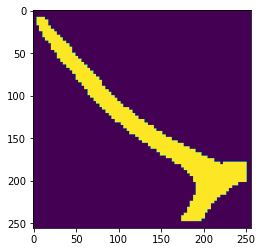

In [7]:
plt.imshow(pots[0])

### Define Hyperparameters

In [35]:
BATCH_SIZE = 128
EPOCHS = 25
LEARNING_RATE = 0.001
LATENT_DIMS = 10

### Prepare data for Autoencoder

#### Train & Test split

In [36]:
trn, tst = train_test_split(pots, test_size=0.20)
print("Train size:  "+ str(len(trn)))
print("Test size:  "+ str(len(tst)))

Train size:  3993
Test size:  999


#### Setting up Dataset transformation

In [37]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [38]:
potds_pytorch_trn = potds_torch(trn, transform=transform)
potds_pytorch_tst = potds_torch(tst, transform=transform)
potds_pytorch = potds_torch(pots, transform=transform)

In [39]:
data_loader_train = DataLoader(dataset = potds_pytorch_trn, batch_size=BATCH_SIZE, shuffle=True)
data_loader_test = DataLoader(dataset = potds_pytorch_tst, batch_size=64, shuffle=True)
data_loader_eval = DataLoader(dataset = potds_pytorch, batch_size=64, shuffle=False)

##### Checking Batch shape and length

In [40]:
x= next(iter(data_loader_train))
x.shape

torch.Size([128, 1, 256, 256])

#### View a Batch

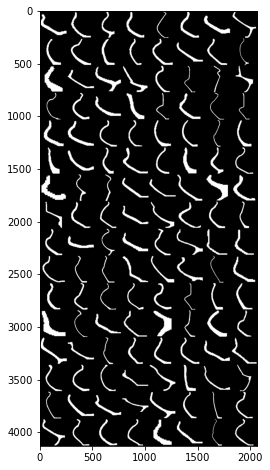

In [41]:
im = make_grid(x, nrow=8)

plt.figure(figsize=(24,8))
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

### Define Autoencoder structure and parameters

In [42]:
from Pots_nn_train import VariationalAutoencoder

In [43]:
### Instancing the model
vae = VariationalAutoencoder(latent_dims=LATENT_DIMS)
### Define loss function and optimizer
optimizer = torch.optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
# Define Recostruction Loss
loss_fn = F.mse_loss

In [44]:
### View the number of tunable parameter
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters: " + str(count_parameters(vae)))

Total number of parameters: 2306293


In [45]:
vae.to(device)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): ReLU(inplace=True)
    (15): Linear(in_features=8192, o

## Training time!

In [46]:
outputs_train, losses_train = TrainingVAE(vae, EPOCHS, data_loader_train,  device, loss_fn, optimizer)

Epoch [1/25] Batch 1/32, Loss : 21162.4355
Epoch [1/25] Batch 2/32, Loss : 20891.3652
Epoch [1/25] Batch 3/32, Loss : 20551.8086
Epoch [1/25] Batch 4/32, Loss : 20300.6914
Epoch [1/25] Batch 5/32, Loss : 20049.2207
Epoch [1/25] Batch 6/32, Loss : 19830.2383
Epoch [1/25] Batch 7/32, Loss : 19627.8984
Epoch [1/25] Batch 8/32, Loss : 19461.6211
Epoch [1/25] Batch 9/32, Loss : 19223.3613
Epoch [1/25] Batch 10/32, Loss : 18976.9941
Epoch [1/25] Batch 11/32, Loss : 18826.6855
Epoch [1/25] Batch 12/32, Loss : 18666.8223
Epoch [1/25] Batch 13/32, Loss : 18458.6797
Epoch [1/25] Batch 14/32, Loss : 18286.4609
Epoch [1/25] Batch 15/32, Loss : 18184.6289
Epoch [1/25] Batch 16/32, Loss : 17981.3457
Epoch [1/25] Batch 17/32, Loss : 17863.5098
Epoch [1/25] Batch 18/32, Loss : 17626.4902
Epoch [1/25] Batch 19/32, Loss : 17531.1074
Epoch [1/25] Batch 20/32, Loss : 17370.5918
Epoch [1/25] Batch 21/32, Loss : 17145.5449
Epoch [1/25] Batch 22/32, Loss : 17075.0332
Epoch [1/25] Batch 23/32, Loss : 16859.57

KeyboardInterrupt: 

### Plot Training recostruction

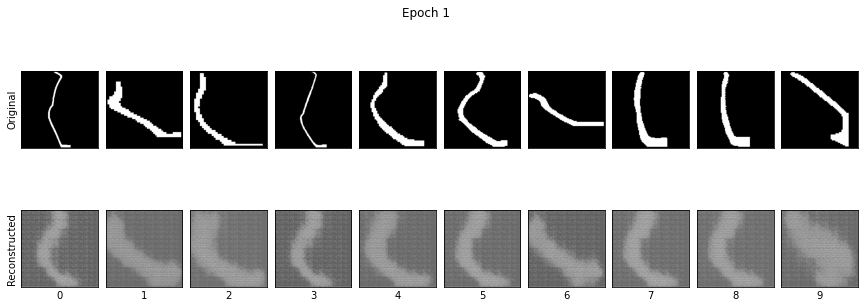

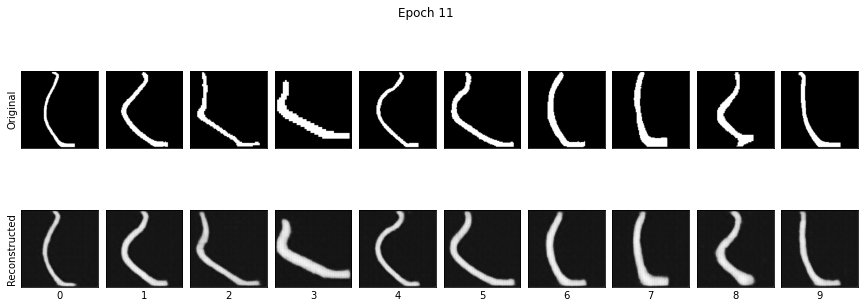

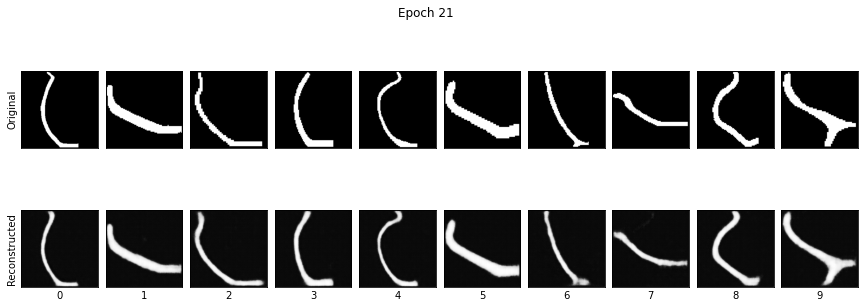

In [ ]:
PlotRecostruction(outputs_train, start = 0, stop = EPOCHS, plt_range = 10, plt_number = 10, QuickCleaning=False,SaveFig=False)

## Testing 

In [ ]:
outputs_tst, losses_tst = TestingVAE(vae, EPOCHS, data_loader_test,  device, loss_fn)

Mean test loss: 1373.63


#### Plotting Test dataset

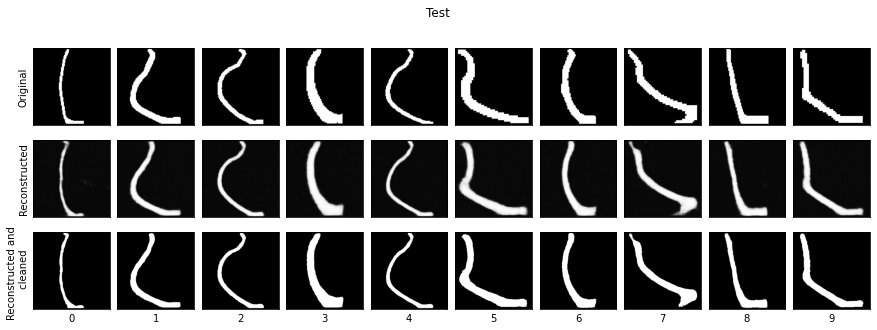

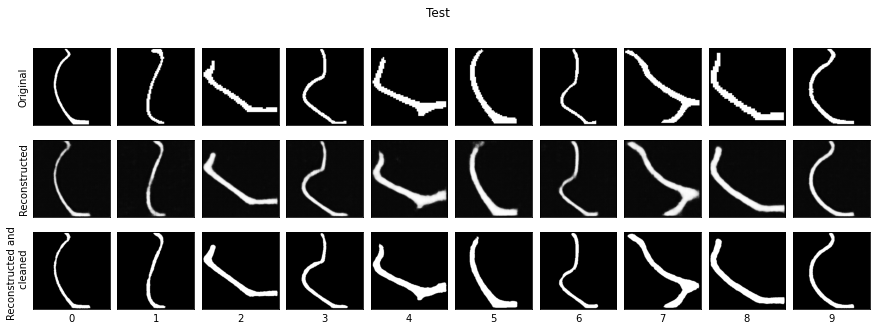

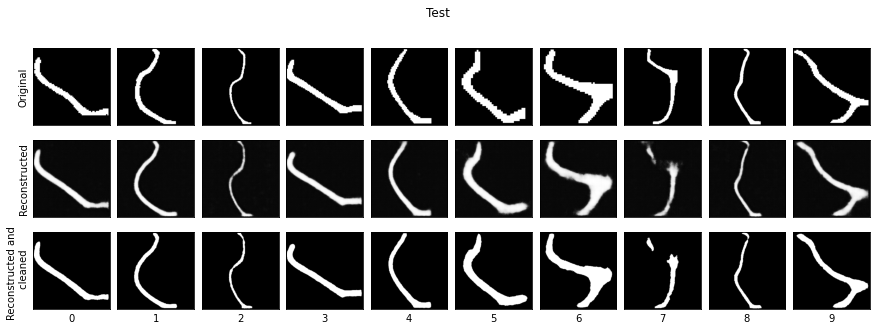

In [ ]:
PlotRecostruction(outputs_tst, start = 0, stop = EPOCHS, plt_range = 10, plt_number = 10, QuickCleaning=True, Training = False)

In [ ]:
prova = vae.sample(100, device)

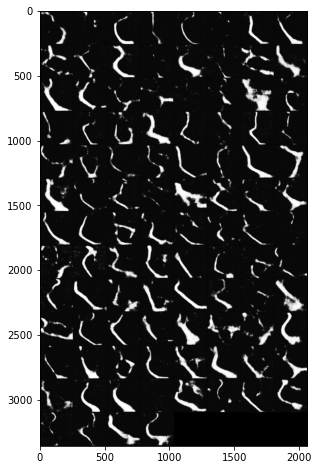

In [ ]:
im = make_grid(prova.to("cpu"), nrow=8)

plt.figure(figsize=(24,8))
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

### Plotting Train and Test Loss

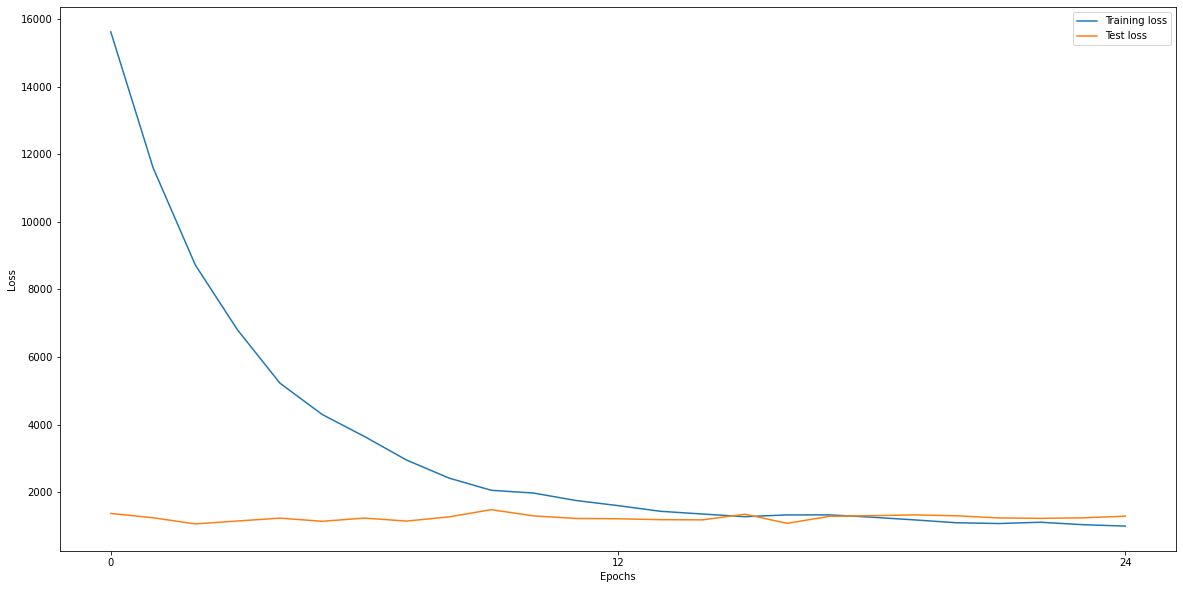

In [ ]:
plt.figure(figsize=(20,10))
plt.plot((np.array(losses_train))[:,1], label = "Training loss")
plt.xticks(np.arange(0, EPOCHS+1, EPOCHS//2))
plt.plot((np.array(losses_tst))[:,1], label = "Test loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

# Accessing Latent Dimension

In [ ]:
encoded_samples = []
for b, img in enumerate(data_loader_eval):
    img = img.to(device)
    vae.to(device)
    vae.eval()
    with torch.no_grad():
        encoded_img, _, _, _  = vae(img.float())
        encoded_img = encoded_img.cpu().numpy()
    encoded_samples.extend(encoded_img)
    encoded_dim = np.array(encoded_samples)

In [ ]:
# Check encoded spaces dimension
encoded_dim.shape

(4992, 10)

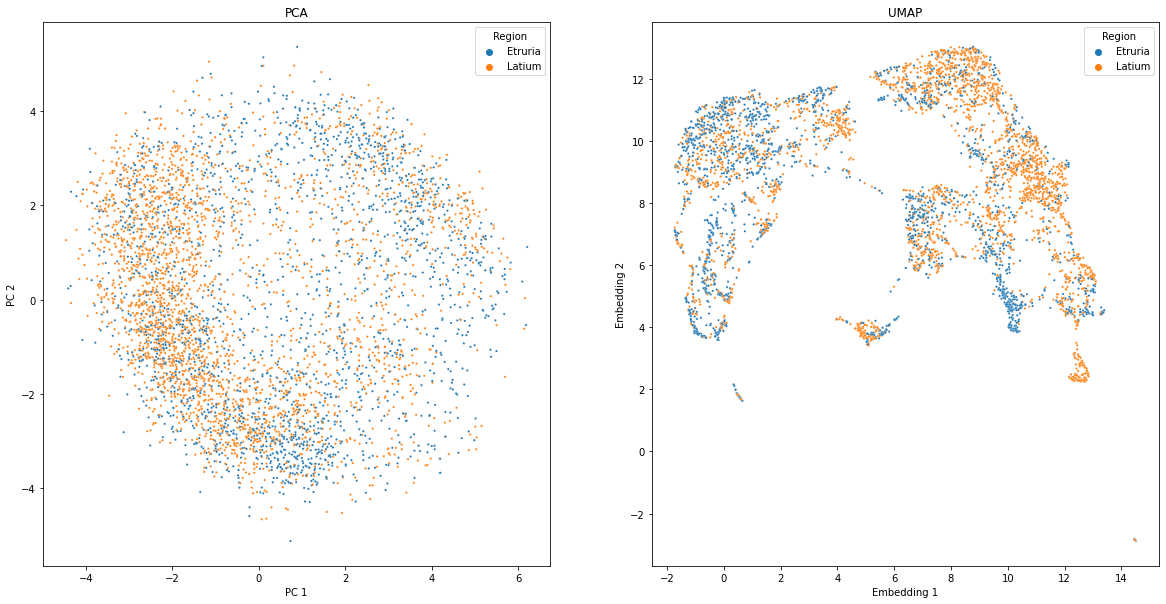

In [ ]:
PlottingEmbeddings(encoded_dim, archeo_info, labels = "Region")

### Normalize encoded dimension

In [52]:
load_excel = True

In [53]:
if load_excel:
    encoded_dim_df = pd.read_excel("encoded_dim.xlsx")
    encoded_dim = MinMaxScaler().fit_transform(encoded_dim_df)
    encoded_df_norm = pd.DataFrame(encoded_dim, archeo_info.index)
else:
    # Normalize encoded data
    encoded_dim_df = pd.DataFrame(encoded_dim, archeo_info.index)
    encoded_dim = MinMaxScaler().fit_transform(encoded_dim)
    encoded_df_norm = pd.DataFrame(encoded_dim, archeo_info.index)


FBA: WD: 0.1618957767570054
EIA1: WD: 0.14291202122405244
EIA2: WD: 0.19468677013869912
OP: WD: 0.08801997235070903


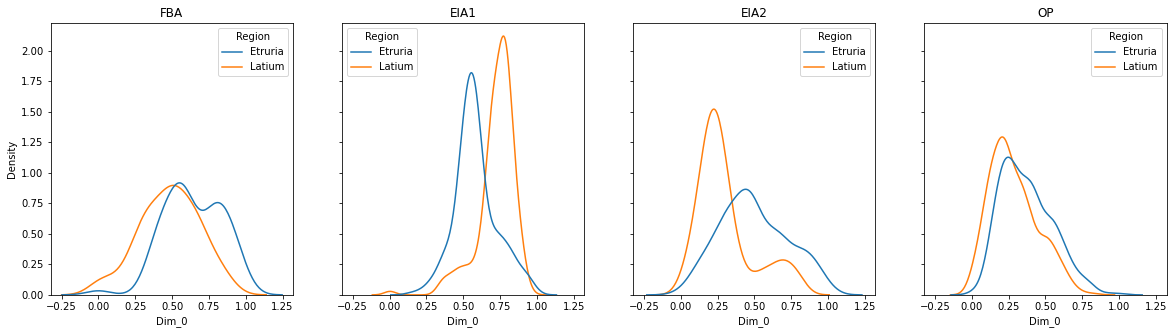

In [54]:
KdePlot(encoded_df_norm, archeo_info, subsampling = True, SaveFig=False)

In [74]:
def WSDist(data, archeo_info, resampling_number = 50, PlotType = "violin", show_points = False, SaveFig = False, return_df = True):
    pipeline = []
    distance_ws = []
    
    chronology = ["FBA", "EIA1", "EIA2", "OP"]
    for n in range(resampling_number):
        with pd.option_context('mode.chained_assignment',None):
            for x, i in enumerate(chronology):
                info_selected_chrono = archeo_info[(archeo_info.chronology == i)]
                pots_chrono = data.loc[info_selected_chrono.index]


                min_number = min(info_selected_chrono.value_counts("Region"))
                max_index = np.argmax(info_selected_chrono.value_counts("Region"))
                max_region = info_selected_chrono.value_counts("Region").index[max_index]

                info_selected_chrono_max_region = info_selected_chrono[(info_selected_chrono.Region == max_region)]
                info_selected_chrono_min_region = info_selected_chrono[(info_selected_chrono.Region != max_region)]
                random_select = info_selected_chrono_max_region.sample(n = min_number)
                
                list1, list2 = list(info_selected_chrono_min_region.index), list(random_select.index)

                list1.extend(list2)

                info_selected_chrono = info_selected_chrono.loc[list1]
                pots_chrono = pots_chrono.loc[list1]

                reduction = NCA(pots_chrono, info_selected_chrono.Region, 1)
                lda_comp_norm = MinMaxScaler().fit_transform(reduction)
                df_values = pd.DataFrame(lda_comp_norm, columns=[f"Dim_{dim}" for dim in range(reduction.shape[1])] , index = info_selected_chrono.index)
                

                info_selected_chrono_joined = info_selected_chrono.join(df_values)
            

                reg_lat = info_selected_chrono_joined[info_selected_chrono_joined.Region == "Latium"]
                reg_etr = info_selected_chrono_joined[info_selected_chrono_joined.Region == "Etruria"]
                w_d = wasserstein_distance(reg_lat["Dim_0"], reg_etr["Dim_0"])
                #print(f"{i}: WD: {w_d}")

                pipeline.append((n, i, w_d))


    df_dist = pd.DataFrame(pipeline, columns =  [["Run", "Epochs", "Wasserstein"]])
    
    fig, ax = plt.subplots(1, 1, figsize = (10,5))
    if PlotType == "boxplot":        
        ax = sns.boxplot(x = df_dist["Epochs"].values.reshape(-1), y =df_dist["Wasserstein"].values.reshape(-1), showmeans=True,meanprops={"marker":"o",
                            "markerfacecolor":"black", 
                            "markeredgecolor":"black",
                            "markersize":"10"})
        if show_points:
            ax = sns.stripplot(x=df_dist["Epochs"].values.reshape(-1), y=df_dist["Wasserstein"].values.reshape(-1),  linewidth=1)
        
        
    elif PlotType == "violin":
        ax = sns.violinplot(x=df_dist["Epochs"].values.reshape(-1), y=df_dist["Wasserstein"].values.reshape(-1))
        if show_points:
            ax = sns.stripplot(x=df_dist["Epochs"].values.reshape(-1), y=df_dist["Wasserstein"].values.reshape(-1),  linewidth=1)
    
    elif PlotType == "points":
        ax = sns.stripplot(x=df_dist["Epochs"].values.reshape(-1), y=df_dist["Wasserstein"].values.reshape(-1),  linewidth=1)

    
    
    else: assert "You can use 'violin', 'boxplot' or 'points' as graph type"
    
    plt.plot()

    if SaveFig:
        fig.savefig(f"WS_plot.jpg", dpi = 300)


    if return_df:
        return df_dist



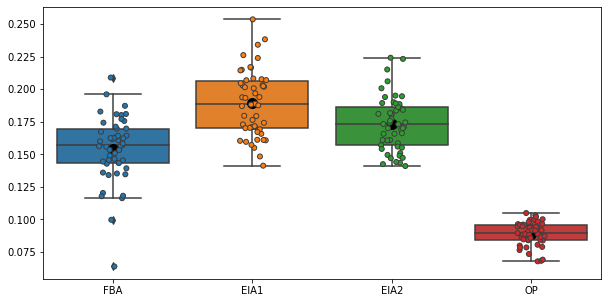

In [76]:
zazzo = WSDist(encoded_df_norm, archeo_info, 50, SaveFig = True, PlotType = "boxplot", show_points= True)

In [ ]:
zazzo

,Run,Epochs,Wasserstein
0,0,FBA,0.160054
1,0,EIA1,0.202444
2,0,EIA2,0.164497
3,0,OP,0.094613
4,1,FBA,0.160973
...,...,...,...
75,18,OP,0.090269
76,19,FBA,0.161487
77,19,EIA1,0.236021
78,19,EIA2,0.167103


In [55]:
from utils_and_plotting import NCA
import seaborn as sns

In [56]:
from scipy.stats import wasserstein_distance

In [57]:
from scipy.spatial import distance

In [58]:
## try with counter-test

In [59]:
chronology = ["FBA", "EIA1", "EIA2", "OP"]
regions = ["Latium", "Etruria"]

In [69]:
wd = []

#fig, ax = plt.subplots(4, 2, sharex="all", sharey="all", figsize = (10,15))
my_list = []
for i, chrono in enumerate(chronology):
    with pd.option_context('mode.chained_assignment',None):
        info_selected_chrono = archeo_info[(archeo_info.chronology == chrono)]


    

        for n in range(0, 20):

            
            info_selected_chrono["random_label"] = np.random.randint(0, 2, size=len(info_selected_chrono))

            nca_test = NCA(encoded_df_norm.loc[info_selected_chrono.index], info_selected_chrono["random_label"], n_components=1)

            info_selected_chrono["nca"] = MinMaxScaler().fit_transform(nca_test)

            info_selected_chrono_0 = info_selected_chrono.loc[info_selected_chrono["random_label"]== 0]
            info_selected_chrono_1 = info_selected_chrono.loc[info_selected_chrono["random_label"]== 1]

            wd_chrono = wasserstein_distance(info_selected_chrono_0["nca"], info_selected_chrono_1["nca"])

            my_list.append((chrono, wd_chrono, len(info_selected_chrono)))

        #wd.append(my_list_df)

        my_list_df = pd.DataFrame(my_list, columns=["Chronology", "W Distance", "samples"])

    #sns.boxplot(data = my_list_df, y = "W Distance", ax = ax[i,r])
    #ax[i,r].set_title(f"{chrono}; {region}")

In [70]:
my_list_df

,Chronology,W Distance,samples
0,FBA,0.037819,264
1,FBA,0.059411,264
2,FBA,0.042025,264
3,FBA,0.044781,264
4,FBA,0.085629,264
...,...,...,...
75,OP,0.024367,1259
76,OP,0.025401,1259
77,OP,0.020623,1259
78,OP,0.015460,1259


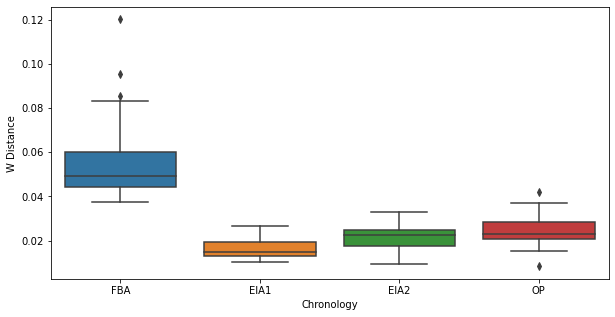

In [73]:
fig, ax = plt.subplots(1, 1, figsize = (10,5))
sns.boxplot(data = my_list_df, y = "W Distance",x = "Chronology")
fig.savefig(f"WS_random_plot.jpg", dpi = 300)

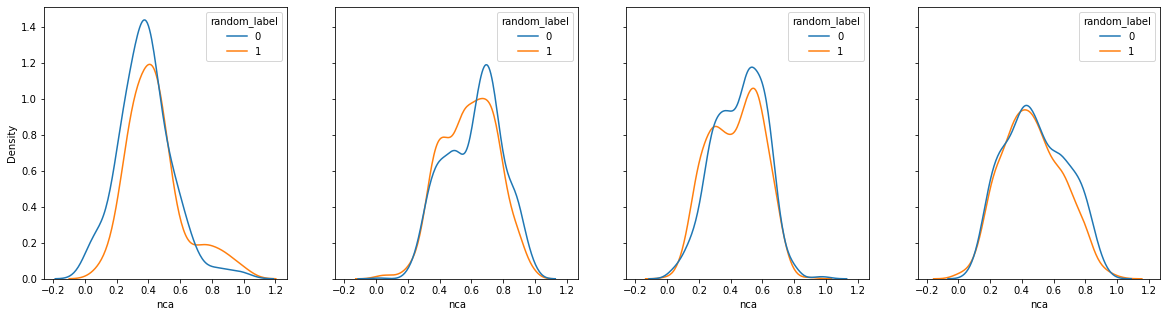

In [68]:
wd = []
with pd.option_context('mode.chained_assignment',None):
    fig, ax = plt.subplots(1, 4, sharex="row", sharey="row", figsize = (20,5))

    for i, chrono in enumerate(chronology):
        info_selected_chrono = archeo_info[(archeo_info.chronology == chrono)]

        info_selected_chrono["random_label"] = np.random.randint(0, 2, size=len(info_selected_chrono))

        nca_test = NCA(encoded_df_norm.loc[info_selected_chrono.index], info_selected_chrono["random_label"], n_components=1)

        info_selected_chrono["nca"] = MinMaxScaler().fit_transform(nca_test)

        info_selected_chrono_0 = info_selected_chrono.loc[info_selected_chrono["random_label"]== 0]
        info_selected_chrono_1 = info_selected_chrono.loc[info_selected_chrono["random_label"]== 1]

        wd_region = wasserstein_distance(info_selected_chrono_0["nca"], info_selected_chrono_1["nca"])

        wd.append((chrono, wd_region, len(info_selected_chrono)))

        sns.kdeplot(data = info_selected_chrono,x = "nca", hue = "random_label", ax = ax[i])

fig.savefig(f"KDE_random.jpg", dpi = 300)

In [ ]:
pd.DataFrame(wd, columns=["Chronology", "wd", "samples"])

,Chronology,wd,samples
0,FBA,0.060777,264
1,EIA1,0.010809,2177
2,EIA2,0.030069,1292
3,OP,0.019039,1259


In [ ]:
latium_EIA1 = archeo_info.loc[(archeo_info["Region"]== "Latium") & (archeo_info["chronology"] == "FBA")]

In [ ]:
encoded_df_norm_test = encoded_df_norm.loc[latium_EIA1.index]

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from utils_and_plotting import NCA
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [ ]:
latium_EIA1["random_label"] = np.random.randint(0, 2, size=len(latium_EIA1))

In [ ]:
nca_test = NCA(encoded_df_norm_test, latium_EIA1["random_label"], n_components=1)

In [ ]:
latium_EIA1["nca"] = MinMaxScaler().fit_transform(nca_test)

<AxesSubplot:xlabel='nca', ylabel='Density'>

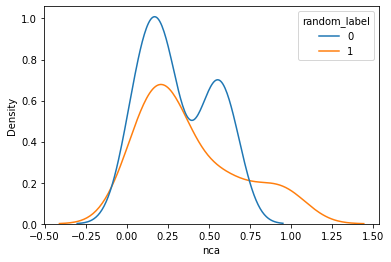

In [ ]:
sns.kdeplot(data = latium_EIA1,x = "nca", hue = "random_label")

<AxesSubplot:xlabel='random_label', ylabel='nca'>

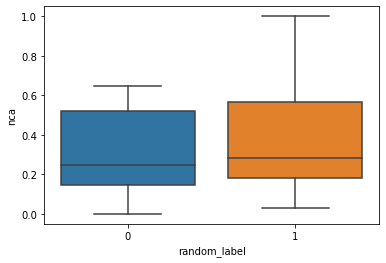

In [ ]:
sns.boxplot(data = latium_EIA1,y = "nca", x = "random_label")

In [ ]:
from scipy.stats import wasserstein_distance

In [ ]:
latium_EIA1

,ids,context_name,context_typology,chronology,funerary_function,context_id,Morphology,Functional_class,Region,random_label,nca
1,ALTR_CNL_0003,Alatri - Canale,Settlement,FBA,NaN,386,Open shape,Class 1,Latium,1,0.577980
44,BSC_DL_PLVRN_0001,Bosco del Polverino,Funerary,FBA,Urn,166,Closed shape,Class 3,Latium,1,0.271707
45,BSC_DL_PLVRN_0002,Bosco del Polverino,Funerary,FBA,Grave good,166,Closed shape,Class 3,Latium,1,0.089309
46,BSC_DL_PLVRN_0003,Bosco del Polverino,Funerary,FBA,Grave good,166,Open shape,Class 2,Latium,0,0.499872
47,BSC_DL_PLVRN_0004,Bosco del Polverino,Funerary,FBA,Grave good,166,Open shape,Class 2,Latium,0,0.519358
...,...,...,...,...,...,...,...,...,...,...,...
4913,VGN_NDR_0003,Vigna D'Andrea,Funerary,FBA,NaN,176,Closed shape,Class 3,Latium,0,0.165249
4914,VGN_NDR_0004,Vigna D'Andrea,Funerary,FBA,NaN,176,Closed shape,Class 3,Latium,0,0.130499
4985,VLL_PZZ_0001,Valle Pozzo,Funerary,FBA,Grave good,145,Closed shape,Class 3,Latium,1,0.296992
4986,VLL_PZZ_0002,Valle Pozzo,Funerary,FBA,Grave good,145,Closed shape,Class 3,Latium,1,0.323937


In [ ]:
latium_EIA1_0 = latium_EIA1.loc[latium_EIA1["random_label"]== 0]
latium_EIA1_1 = latium_EIA1.loc[latium_EIA1["random_label"]== 1]

In [ ]:
wasserstein_distance(latium_EIA1_0["nca"], latium_EIA1_1["nca"])

0.07770208031928136